# Baselines evaluation 

In [1]:
import os
from pathlib import Path
# config_name = "medmnist/pathmnist_resnet_dropout_all_layers.yml"
# config_name = Path(os.getcwd()).parent / "configs" / "busi" / "busi_resnet.yml"
config_name = Path(os.getcwd()).parent / "configs" / "rsna" / "rsna_resnet50_dropout_all_layers.yml"
# scores_filename = Path(os.getcwd()).parent / "outputs" / "BUSI" / "resnet18" / "dropout_all_layers_autolr_longer" / "seed_55" / "failure_detection" / "scores_df.csv"
# scores_filename = Path(os.getcwd()).parent / "outputs" / "RSNAPneumonia" / "resnet50" / "dropout_all_layers_autolr_paper" / "seed_55" / "failure_detection" / "scores_df.csv"
# scores_filename = Path(os.getcwd()).parent / "outputs" / "RSNAPneumonia" / "resnet50" / "dropout_all_layers_autolr_paper" / "seed_42" / "failure_detection" / "scores_df.csv"
# scores_filename = Path(os.getcwd()).parent / "outputs" / "RSNAPneumonia" / "resnet50" / "dropout_all_layers_autolr_paper" / "seed_84" / "failure_detection" / "scores_df.csv"
# scores_filename = Path(os.getcwd()).parent / "outputs" / "RSNAPneumonia" / "resnet50" / "dropout_all_layers_autolr_paper" / "seed_21" / "failure_detection" / "scores_df.csv"
scores_filename = Path(os.getcwd()).parent / "outputs" / "RSNAPneumonia" / "resnet50" / "dropout_all_layers_autolr_paper" / "seed_10" / "failure_detection" / "scores_df.csv"

In [2]:
import sys
import os
from configs.default_config import load_yaml_training_config
from failure_detection.evaluator import ThresholdBasedEvaluator
from failure_detection.run_evaluation import get_all_scores
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
print(config_name)      # Debugging
config = load_yaml_training_config(config_name)

if not Path(scores_filename).exists():
    print("Score dataframe not created yet, running scores script")
    scores_df = get_all_scores(config_name)
else:
    scores_df = pd.read_csv(scores_filename)

if config.n_classes > 2:
    scores_df["mcmc_probas"] = None
    scores_df["Probas"] = None
    scores_df["Laplace_probas"] = None
    scores_df["SWAG_probas"] = None

C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\configs\rsna\rsna_resnet50_dropout_all_layers.yml
Loading config from C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\configs\rsna\rsna_resnet50_dropout_all_layers.yml


## A look at the model

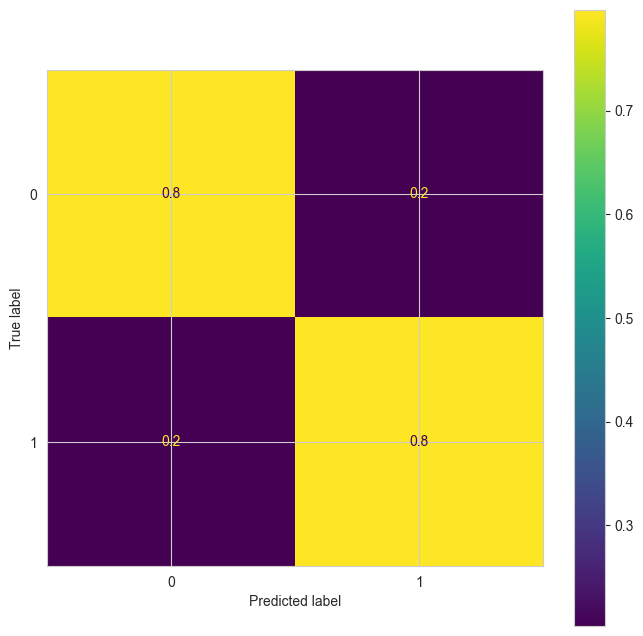

In [3]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    scores_df["Targets"].astype(int).values,
    scores_df["Predictions"].astype(int).values,
    normalize="true",
    ax=ax,
)

In [4]:
from sklearn.metrics import accuracy_score

print(
    f'Acc: {accuracy_score(scores_df["Targets"].astype(int).values, scores_df["Predictions"].astype(int).values):.3f}'
)

Acc: 0.797


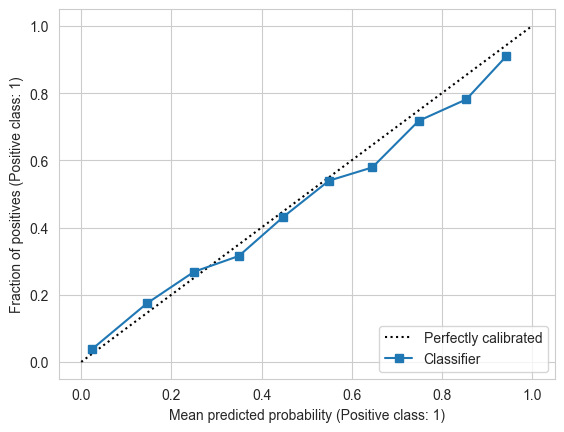

In [5]:
if config.n_classes == 2:
    CalibrationDisplay.from_predictions(
        scores_df["Targets"].values, scores_df["Probas"].values, n_bins=10
    )

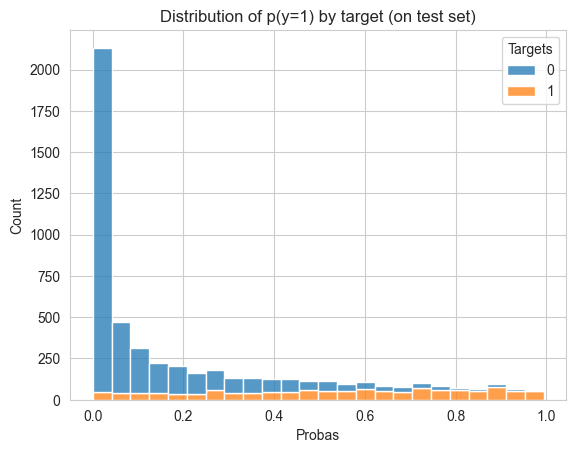

In [7]:
if config.n_classes == 2:
    sns.histplot(x=scores_df["Probas"], hue=scores_df["Targets"], multiple="stack")
    plt.title("Distribution of p(y=1) by target (on test set)")
    plt.show()

## Get Softmax baseline results

In [8]:
evaluator_baseline = ThresholdBasedEvaluator(
    scores_df["Baseline"],
    scores_df["Predictions"],
    scores_df["Targets"],
    scores_df["Probas"],
    "Baseline",
)
all_metrics = evaluator_baseline.get_new_metrics();

In [8]:
all_metrics

,Scorer,FPR_TPR95,FPR_TPR80,ROC_AUC_error_detection_global,Original_Accuracy,Original_ROC_AUC
0,Baseline,0.629493,0.279263,0.845689,0.796702,0.866136


## Get DOCTOR results

In [9]:
if "doctor_alpha" in scores_df.columns:
    evaluator_alpha = ThresholdBasedEvaluator(
        scores_df["doctor_alpha"],
        scores_df["Predictions"],
        scores_df["Targets"],
        scores_df["Probas"],
        "DoctorAlpha",
    )
    all_metrics = all_metrics.append(
        evaluator_alpha.get_new_metrics(), ignore_index=True
    )

if "doctor_alpha_pbb" in scores_df.columns:
    evaluator_alpha_pbb = ThresholdBasedEvaluator(
        scores_df["doctor_alpha_pbb"],
        scores_df["Predictions"],
        scores_df["Targets"],
        scores_df["Probas"],
        "DoctorAlphaPBB",
    )
    all_metrics = all_metrics.append(
        evaluator_alpha_pbb.get_new_metrics(), ignore_index=True
    )

## Get TrustScore results

In [10]:
if "TrustScore" in scores_df.columns:
    evaluator_trustscore = ThresholdBasedEvaluator(
        scores_df["TrustScore"],
        scores_df["Predictions"],
        scores_df["Targets"],
        scores_df["Probas"],
        "Trust Score",
    )
    all_metrics = all_metrics.append(
        evaluator_trustscore.get_new_metrics(), ignore_index=True
    )

## MCMC dropout

In [11]:
if "mcmc_soft_scores" in scores_df.columns:
    evaluator_mcmcmean_agg = ThresholdBasedEvaluator(
        scores_df["mcmc_soft_scores"],
        scores_df["mcmc_predictions"],
        scores_df["Targets"],
        scores_df["mcmc_probas"],
        "MCMC Average Softmax score - Agg pred",
    )
    all_metrics = all_metrics.append(
        evaluator_mcmcmean_agg.get_new_metrics(), ignore_index=True
    )
    evaluator_mcmcmean_agg = ThresholdBasedEvaluator(
        scores_df["mcmc_entropy_scores"],
        scores_df["mcmc_predictions"],
        scores_df["Targets"],
        scores_df["mcmc_probas"],
        "MCMC Entropy score - Agg pred",
    )
    all_metrics = all_metrics.append(
        evaluator_mcmcmean_agg.get_new_metrics(), ignore_index=True
    )
    display(all_metrics)

,Scorer,FPR_TPR95,FPR_TPR80,ROC_AUC_error_detection_global,Original_Accuracy,Original_ROC_AUC
0,Baseline,0.611418,0.243094,0.860448,0.796515,0.877434
1,DoctorAlpha,0.789134,0.243094,0.843352,0.796515,0.877434
2,Trust Score,0.719153,0.335175,0.818850,0.796515,0.877434
3,MCMC Average Softmax score - Agg pred,0.614458,0.246525,0.859989,0.797826,0.877819
4,MCMC Entropy score - Agg pred,0.812790,0.246525,0.836147,0.797826,0.877819


## Laplace

In [12]:
if "Laplace_predictions" in scores_df.columns:
    evaluator_laplace = ThresholdBasedEvaluator(
        scores_df["Laplace_score"],
        scores_df["Laplace_predictions"],
        scores_df["Laplace_targets"],
        scores_df["Laplace_probas"],
        "Laplace",
    )
    all_metrics = all_metrics.append(
        evaluator_laplace.get_new_metrics(), ignore_index=True
    )

## ConfidNet

In [13]:
if "ConfidNet_scores" in scores_df.columns:
    evaluator_confidNet = ThresholdBasedEvaluator(
        scores_df["ConfidNet_scores"],
        scores_df["Predictions"],
        scores_df["Targets"],
        scores_df["Probas"],
        "ConfidNet",
    )
    all_metrics = all_metrics.append(
        evaluator_confidNet.get_new_metrics(), ignore_index=True
    )

## SWAG

In [14]:
if "SWAG_score" in scores_df.columns:
    evaluator_swag = ThresholdBasedEvaluator(
        scores_df["SWAG_score"],
        scores_df["SWAG_predictions"],
        scores_df["SWAG_targets"],
        scores_df["SWAG_probas"],
        "SWAG",
    )
    all_metrics = all_metrics.append(
        evaluator_swag.get_new_metrics(), ignore_index=True
    )

## DUQ

In [20]:
if "DUQ_score" in scores_df.columns:
    evaluator_duq = ThresholdBasedEvaluator(
        scores_df["DUQ_score"],
        scores_df["DUQ_predictions"],
        scores_df["Targets"],
        scores_df["DUQ_probas"],
        "DUQ",
    )
    all_metrics = all_metrics.append(evaluator_duq.get_new_metrics(), ignore_index=True)

In [15]:
all_metrics.to_csv(Path(scores_filename).parent / f"all_metrics.csv", index=False)
all_metrics

,Scorer,FPR_TPR95,FPR_TPR80,ROC_AUC_error_detection_global,Original_Accuracy,Original_ROC_AUC
0,Baseline,0.611418,0.243094,0.860448,0.796515,0.877434
1,DoctorAlpha,0.789134,0.243094,0.843352,0.796515,0.877434
2,Trust Score,0.719153,0.335175,0.818850,0.796515,0.877434
3,MCMC Average Softmax score - Agg pred,0.614458,0.246525,0.859989,0.797826,0.877819
4,MCMC Entropy score - Agg pred,0.812790,0.246525,0.836147,0.797826,0.877819
5,Laplace,0.605672,0.241537,0.861493,0.795203,0.877421
6,ConfidNet,0.812155,0.243094,0.836589,0.796515,0.877434
7,SWAG,0.639135,0.308751,0.835615,0.809444,0.872902
